In [2]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q

!pip install opendatasets -q

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od

In [4]:
od.download("https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: thakshakarathnayake
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification


100%|██████████| 217M/217M [00:00<00:00, 848MB/s] 


In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

In [6]:
train_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/train"
test_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/test"

In [7]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [8]:
class_names = train_data.class_names
class_names

['cats', 'dogs']

In [9]:
for image_batch, label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 128, 128, 3)
(32,)


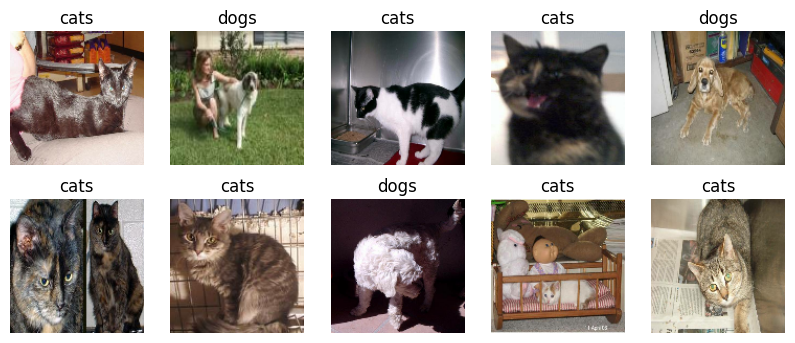

In [10]:
plt.figure(figsize=(10,4))
for image, label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

# Data Preprocessing

## Scaling Images (Normalization)

In [11]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[101.00769   104.00769   109.00769  ]
   [111.074585  112.71521   114.30505  ]
   [117.635284  115.31354   112.59396  ]
   ...
   [129.86246   132.91324   136.22964  ]
   [126.8725    133.10297   135.69281  ]
   [128.9002    138.99207   139.94614  ]]

  [[ 85.20029    88.20029    93.20029  ]
   [ 99.3725     99.79227   101.78906  ]
   [114.00287   112.997925  110.048706 ]
   ...
   [116.720825  120.720825  123.720825 ]
   [119.9389    126.16937   128.75922  ]
   [138.79547   147.0824    148.93893  ]]

  [[ 92.54297    94.90234    99.58203  ]
   [ 91.57605    91.986206   93.986206 ]
   [105.38388   104.38388   101.75107  ]
   ...
   [120.73743   125.52237   128.52237  ]
   [130.21445   135.21445   138.21445  ]
   [127.32648   134.36554   136.68585  ]]

  ...

  [[118.07504   122.07504   125.07504  ]
   [121.617584  125.617584  128.61758  ]
   [130.54602   134.54602   137.54602  ]
   ...
   [ 81.51825    87.02301    96.76108  ]
   [ 45.951294   50.819916   54.147003 ]
   [ 

In [12]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

In [13]:
for image, label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[0.15117954 0.08451287 0.12372855]
   [0.1564951  0.08982843 0.12904412]
   [0.14387254 0.07720588 0.11642157]
   ...
   [0.         0.00392157 0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.15078124 0.08411458 0.12333027]
   [0.1463848  0.07971814 0.11893383]
   [0.13852635 0.07185968 0.11107536]
   ...
   [0.         0.         0.        ]
   [0.         0.00127145 0.        ]
   [0.         0.         0.        ]]

  [[0.15681386 0.09014719 0.12936288]
   [0.15010071 0.08343404 0.12264973]
   [0.1491728  0.08250613 0.12172181]
   ...
   [0.00392157 0.         0.        ]
   [0.         0.00392157 0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.7237403  0.6738876  0.726761  ]
   [0.7528033  0.7035823  0.75956535]
   [0.77319306 0.71951526 0.7698836 ]
   ...
   [0.04705882 0.00392157 0.03529412]
   [0.05098039 0.         0.03529412]
   [0.0395804  0.         0.03137255]]

  [[0.7596398  0.66668636 0.694030

## Transfer Learning

In [20]:
pretrained_model = tf.keras.applications.xception.Xception(include_top=False, # Remove final layer because we only need 2 nodes for binary classification but this has more than 1000 nodes
                                                           input_shape=(128,128,3),
                                                           weights="imagenet",
                                                           pooling='max')

for layer in pretrained_model.layers:
  layer.trainable=False # No need to train layers again, already trained

# Model Building

In [21]:
model = tf.keras.models.Sequential()

model.add(pretrained_model)

model.add(tf.keras.layers.Flatten())

# If want we can add more hidden layers
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))

model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,144,425 (80.66 MB)

 Trainable params: 282,945 (1.08 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Compile Model

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Model Training

In [25]:
start_time = time.time()

epoch_number = 3 # Decrease epochs because we are using a well pretrained model

history = model.fit(train_data,
                    epochs=epoch_number,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.9504 - loss: 0.1180 - val_accuracy: 0.9513 - val_loss: 0.1161
Epoch 2/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9624 - loss: 0.0951 - val_accuracy: 0.9563 - val_loss: 0.1075
Epoch 3/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9665 - loss: 0.0862 - val_accuracy: 0.9513 - val_loss: 0.1372


In [27]:
print(f'Total time for training {(end_time-start_time):.3f} seconds')

Total time for training 37.998 seconds


In [28]:
history.history

{'accuracy': [0.9520833492279053, 0.9620833396911621, 0.9686111211776733],
 'loss': [0.11416420340538025, 0.09263532608747482, 0.08108237385749817],
 'val_accuracy': [0.9512500166893005, 0.956250011920929, 0.9512500166893005],
 'val_loss': [0.11610033363103867, 0.10749199986457825, 0.13721336424350739]}

# Performance Analysis

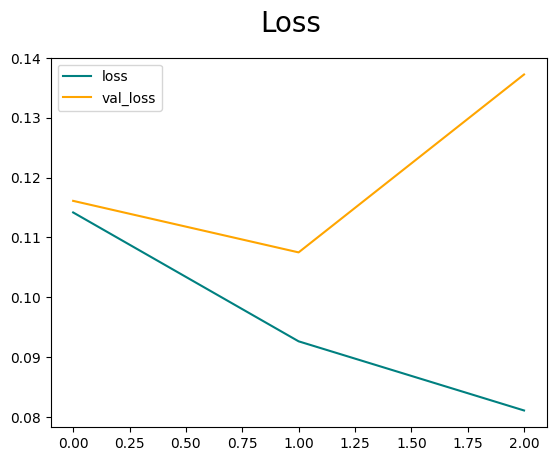

In [29]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

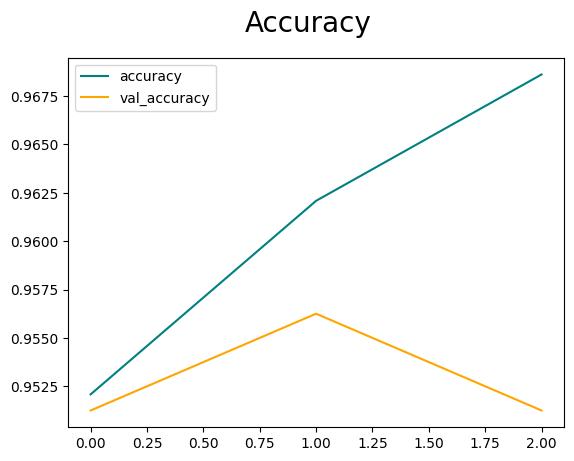

In [31]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

# Model Evaluation

In [32]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [34]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━

In [36]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9079925417900085>

In [37]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9769999980926514>

In [38]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9390000104904175>

# Prediction Pipeline

In [39]:
!pip install opencv-python -q

In [40]:
import cv2

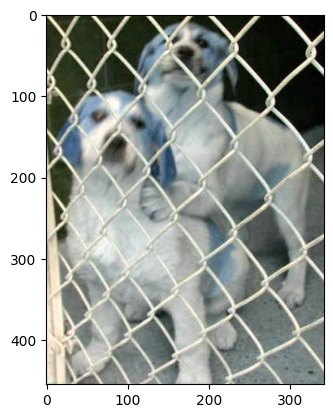

In [41]:
img = cv2.imread('/content/cats-and-dogs-for-classification/cats_dogs/test/dogs/dog.4008.jpg')
plt.imshow(img)
plt.show()

In [42]:
resized_image = tf.image.resize(img, IMAGE_SIZE)
scaled_image = resized_image/255

In [43]:
scaled_image.shape

TensorShape([128, 128, 3])

In [44]:
np.expand_dims(scaled_image, 0).shape

(1, 128, 128, 3)

In [45]:
yhat = model.predict(np.expand_dims(scaled_image, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


In [46]:
yhat

array([[0.9999895]], dtype=float32)

In [47]:
class_names

['cats', 'dogs']

In [48]:
if yhat >= 0.5:
    print(f'{class_names[1]}')
else:
    print(f'{class_names[0]}')

dogs
